## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [5]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [6]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [7]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [8]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (171382, 8)


In [9]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:00:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:15:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:30:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:45:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:00:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1657683000,1657683000,19520.30,19538.00,19460.00,19476.73,1050.976200,27815.0,2022-07-13 03:30:00,2022-07-13 03:45:00
1657683900,1657683900,19476.73,19489.75,19463.54,19473.68,637.998460,21309.0,2022-07-13 03:45:00,2022-07-13 04:00:00
1657684800,1657684800,19473.68,19511.06,19468.19,19499.81,767.171540,21170.0,2022-07-13 04:00:00,2022-07-13 04:15:00


### Plot wick Candles and build features from technical analysis

In [10]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:15:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:30:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:45:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:00:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-07-13 03:30:00,19460.00,19538.00,19520.30,19476.73,1050.976200
2022-07-13 03:45:00,19463.54,19489.75,19476.73,19473.68,637.998460
2022-07-13 04:00:00,19468.19,19511.06,19473.68,19499.81,767.171540


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

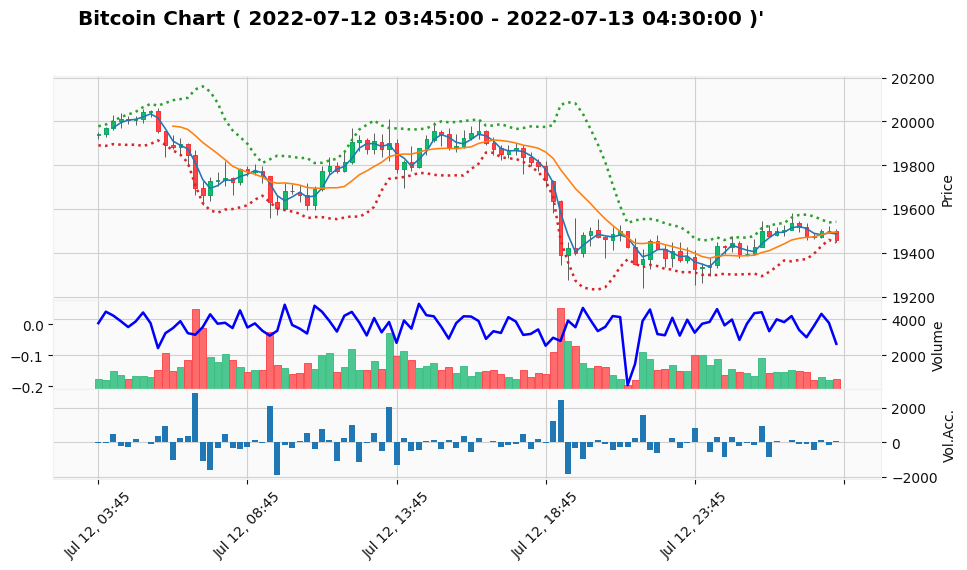

In [11]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [12]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [13]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.scaler
ts_btc.y[-10:]

[0.3516839886553494,
 0.35185361212402644,
 0.35192672411830855,
 0.3522219946008204,
 0.35204190054765716,
 0.35165712932992815,
 0.35162935951889945,
 0.3518672694081389,
 0.3518868448487001,
 0.3515041677478684]

## Train a CNN-LSTM model 

In [14]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.9)

In [15]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['candles[0][0]']                
                                                                                              

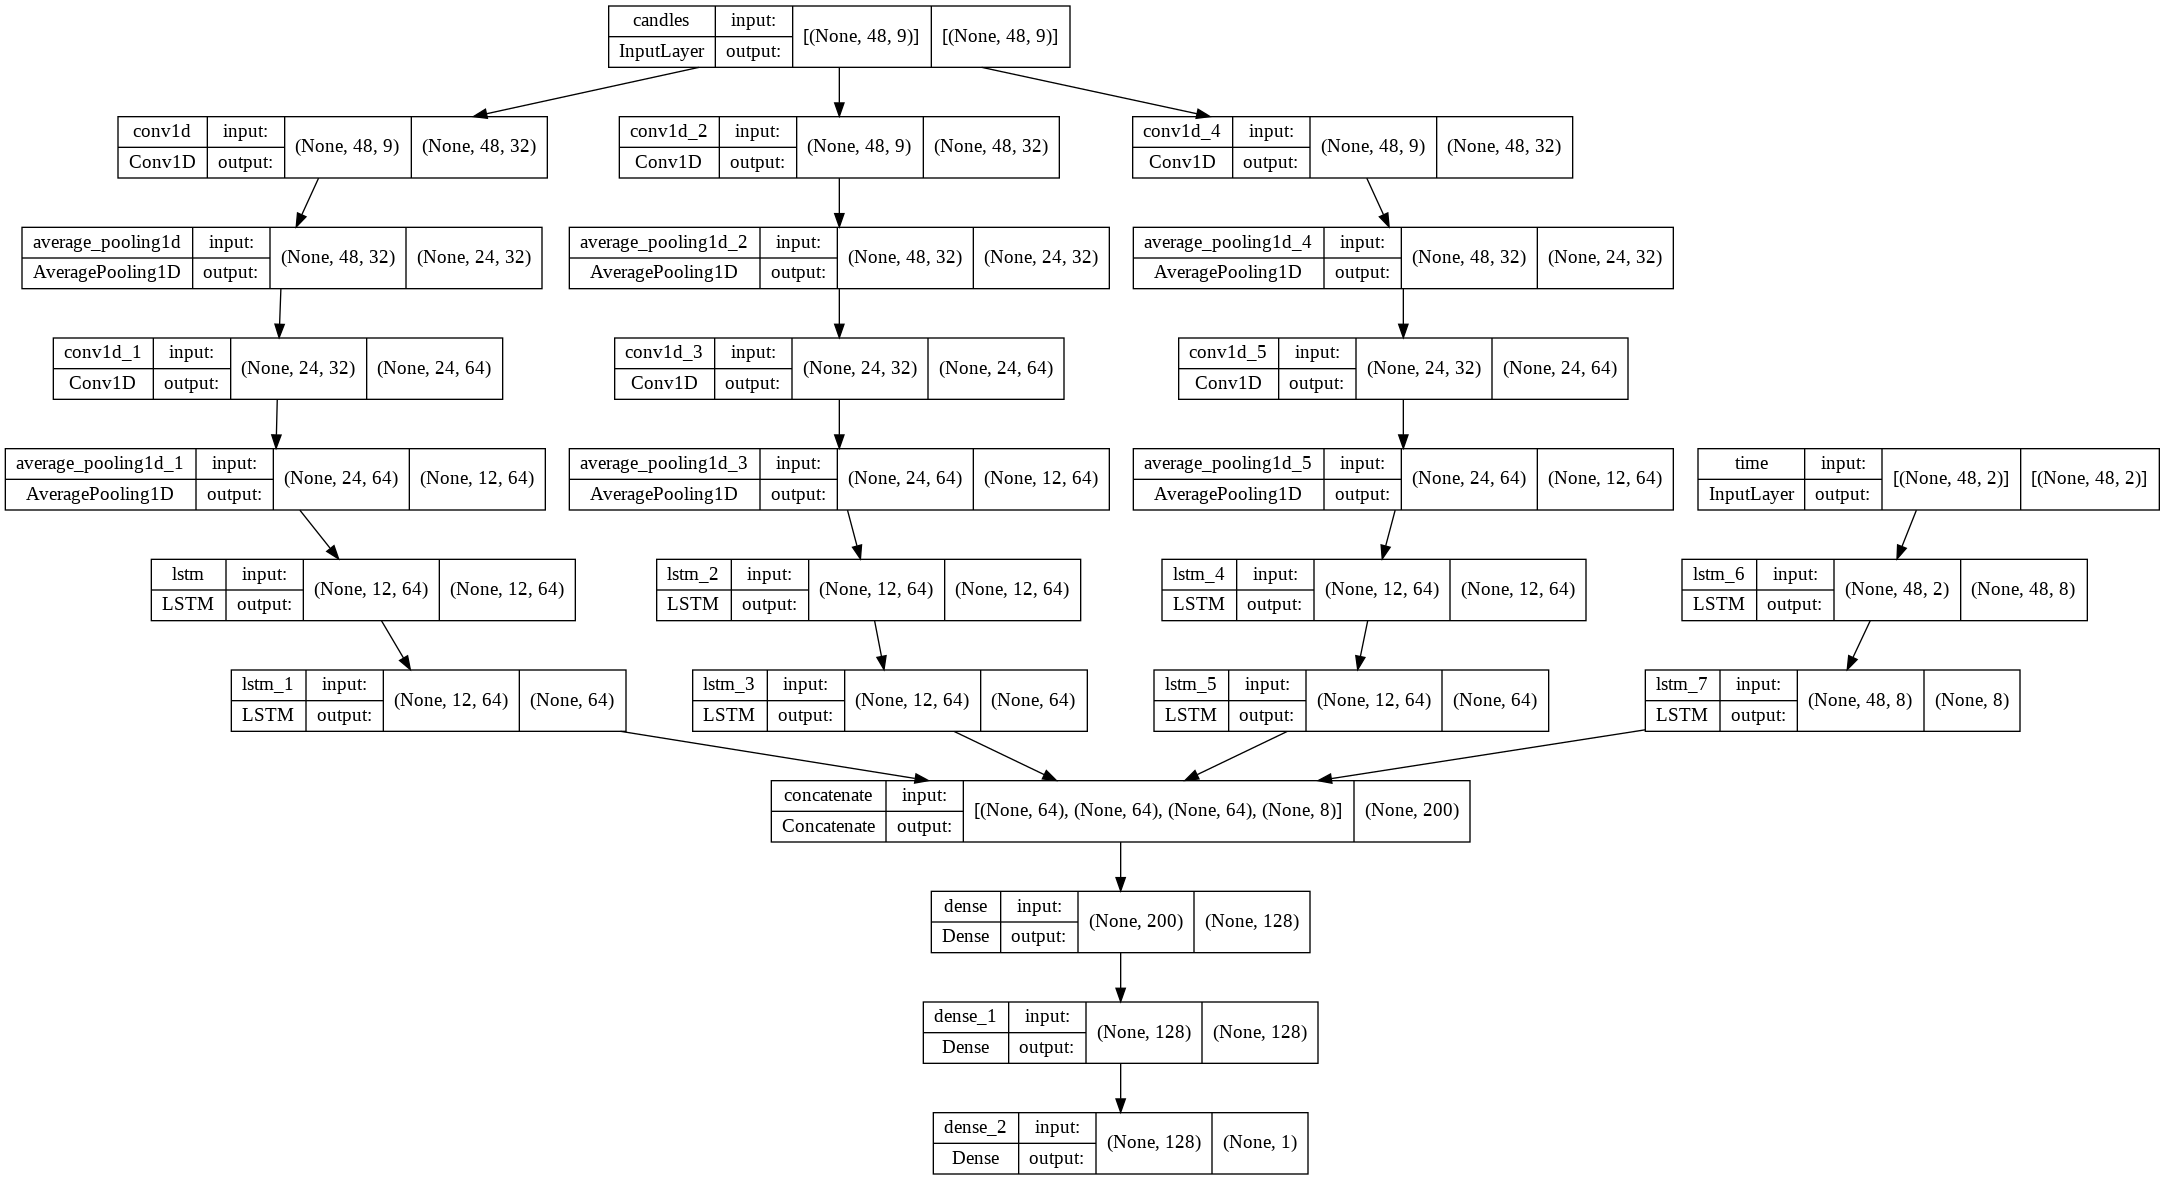

In [16]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [17]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name,save_model = False)

Epoch 1/20
11/11 [==============================] - 15s 380ms/step - loss: 0.2057 - val_loss: 0.1612
Epoch 2/20
11/11 [==============================] - 1s 96ms/step - loss: 0.0570 - val_loss: 0.1048
Epoch 3/20
11/11 [==============================] - 1s 97ms/step - loss: 0.0389 - val_loss: 0.0732
Epoch 4/20
11/11 [==============================] - 1s 96ms/step - loss: 0.0244 - val_loss: 0.0347
Epoch 5/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0548 - val_loss: 0.0691
Epoch 6/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0445 - val_loss: 0.0120
Epoch 7/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0269 - val_loss: 0.0191
Epoch 8/20
11/11 [==============================] - 1s 96ms/step - loss: 0.0170 - val_loss: 0.0130
Epoch 9/20
11/11 [==============================] - 1s 97ms/step - loss: 0.0090 - val_loss: 0.0037
Epoch 10/20
11/11 [==============================] - 1s 96ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 1

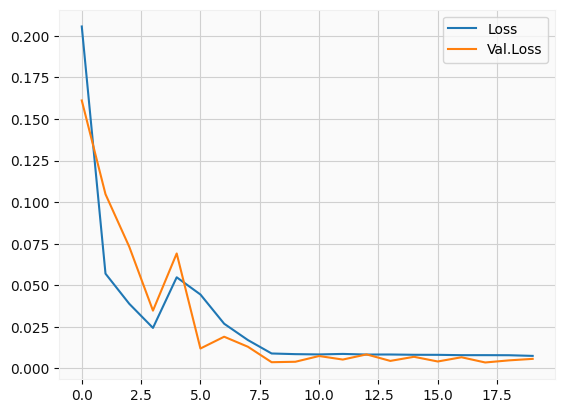

In [18]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [19]:
btc_model.sats2pred(predict_on_test = True)

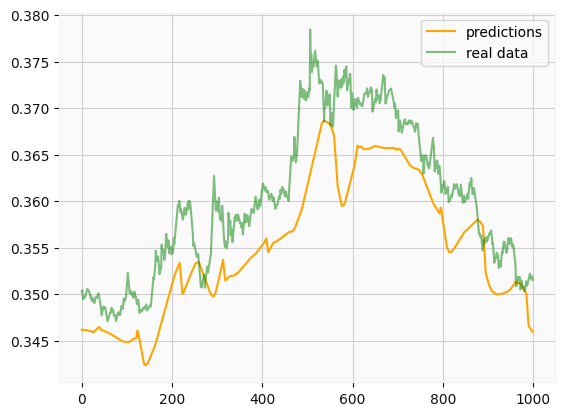

In [20]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [21]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

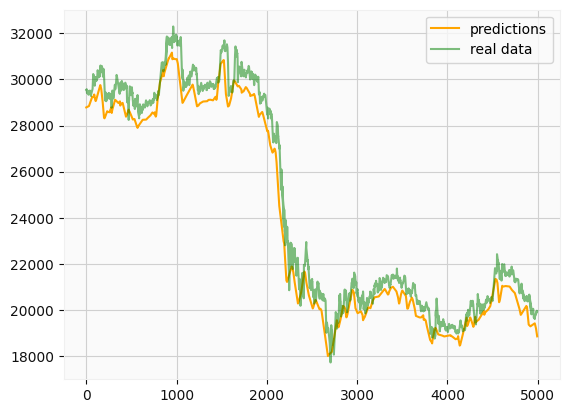

In [22]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Back-testing buy or do nothing, i.e. up-only

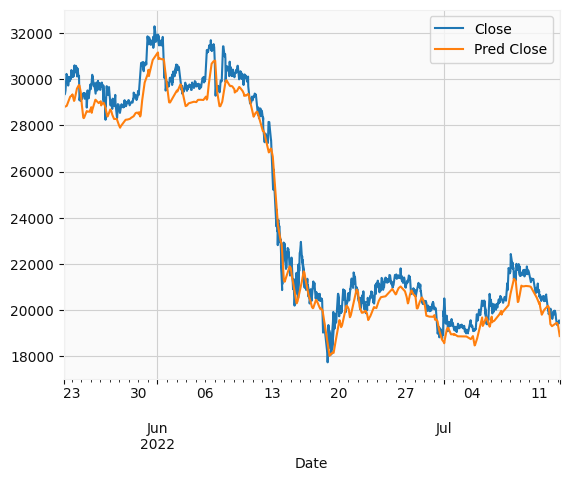

In [23]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Initial time 2022-05-22 04:00:00
Final time 2022-07-13 04:30:00
Fee: 0.025
----------------------
Buy      210 ( 146 ok 64 ko )
Avg PCT gain: 1.0051590290278347
Avg PCT loss: 0.9958775772193685
Wins  PCT   0.6952380952380952
Avg PCT Gain.    1.0051590290278347
No-op    4736
Wallet   9743.325499999999
Drawback -627.4024999999986
Kelly Fraction    0.3932903053081884
Total earned 9743.325499999999


/content/drive/MyDrive/Colab Notebooks/sats4u/src/sats2backtest.py:438: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(wallet_hist_df.index, wallet_hist_df.iloc[:, 1])


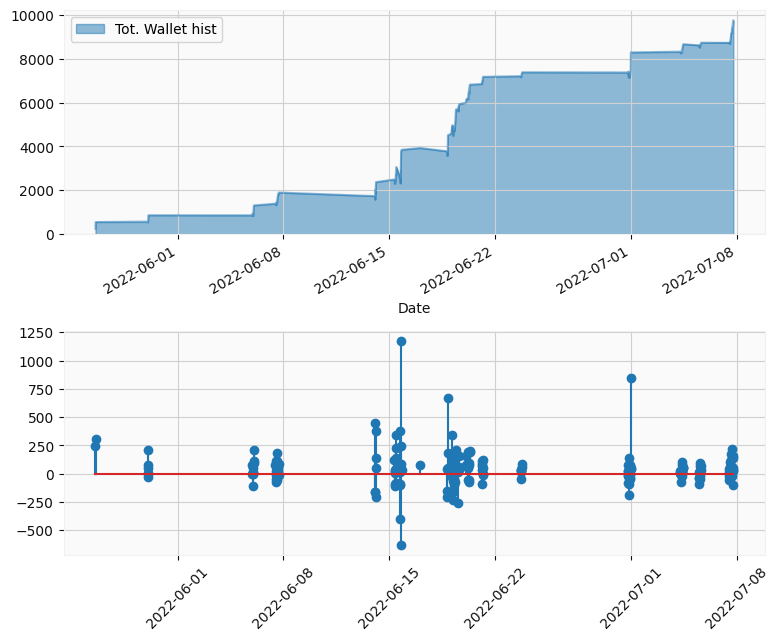

In [24]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 48,
                                                long_short = "long", compare_true_data=True,
                                                fee=0.025, cutoff_long =10. ,cutoff_short = 10.0)
s2b.show_backtest_results(wallet,wallet_hist_df)

## Train for more epochs

In [25]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [26]:
btc_model.sats2train(model_name, save_model = False, epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0075 - val_loss: 0.0056
Epoch 2/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 3/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0075 - val_loss: 0.0059
Epoch 4/100
11/11 [==============================] - 1s 98ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 5/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 6/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 7/100
11/11 [==============================] - 1s 95ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 8/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 9/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 10/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0069 - val_loss: 0.006

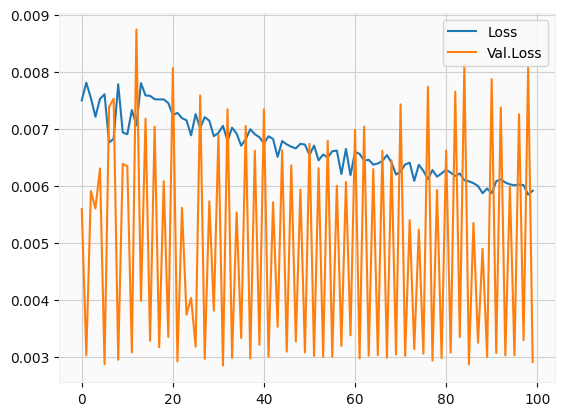

In [27]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [28]:
btc_model.sats2pred(predict_on_test = True)

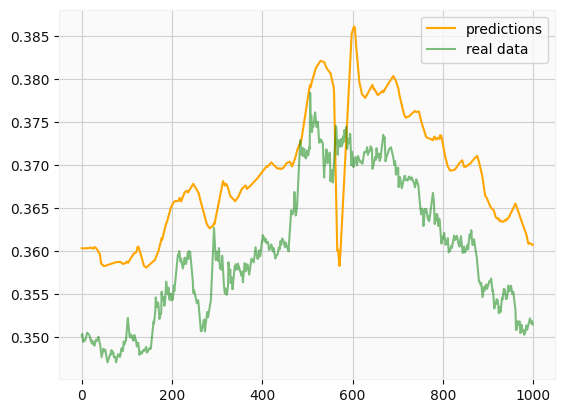

In [29]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [30]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Initial time 2022-05-22 04:00:00
Final time 2022-07-13 04:30:00
Fee: 0.025
----------------------
Buy      292 ( 132 ok 160 ko )
Avg PCT gain: 1.003267131874352
Avg PCT loss: 0.9965557892351529
Wins  PCT   0.4520547945205479
Avg PCT Gain.    1.003267131874352
No-op    4700
Wallet   -3108.8905000000022
Drawback -593.0752500000006
Kelly Fraction    -0.09222493851926722
Total earned -3108.8905000000022


/content/drive/MyDrive/Colab Notebooks/sats4u/src/sats2backtest.py:438: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(wallet_hist_df.index, wallet_hist_df.iloc[:, 1])


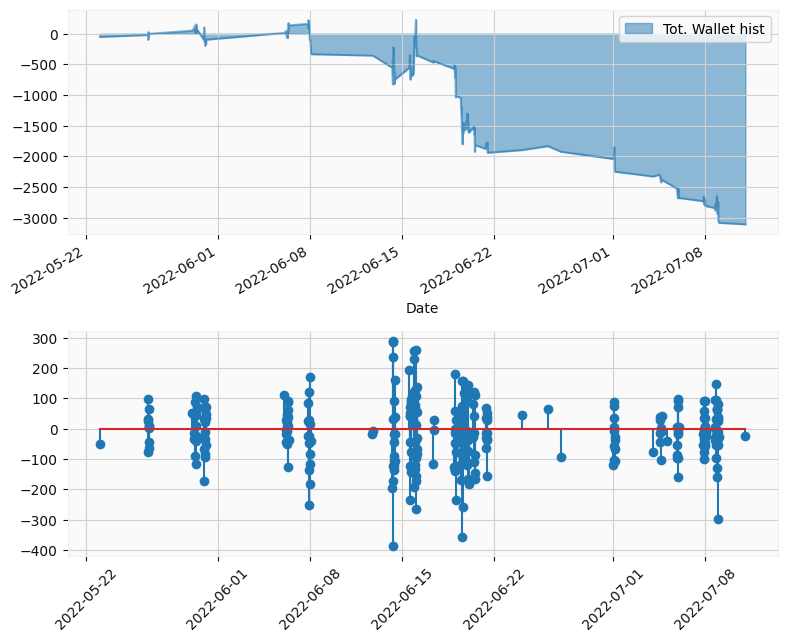

In [31]:
df_preds_true = tu.merge_true_preds(can_btc.candles, preds, period=+1)

wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 2,
                                                     long_short="long", fee=0.025, cutoff_long=20., cutoff_short=20.0)
s2b.show_backtest_results(wallet, wallet_hist_df)


In [32]:
df_pred_exp = pd.DataFrame(np.array([preds,true_vals[-len(preds):]]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = tu.log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = tu.log_return(df_pred_exp["Predicted"],periods=-1)


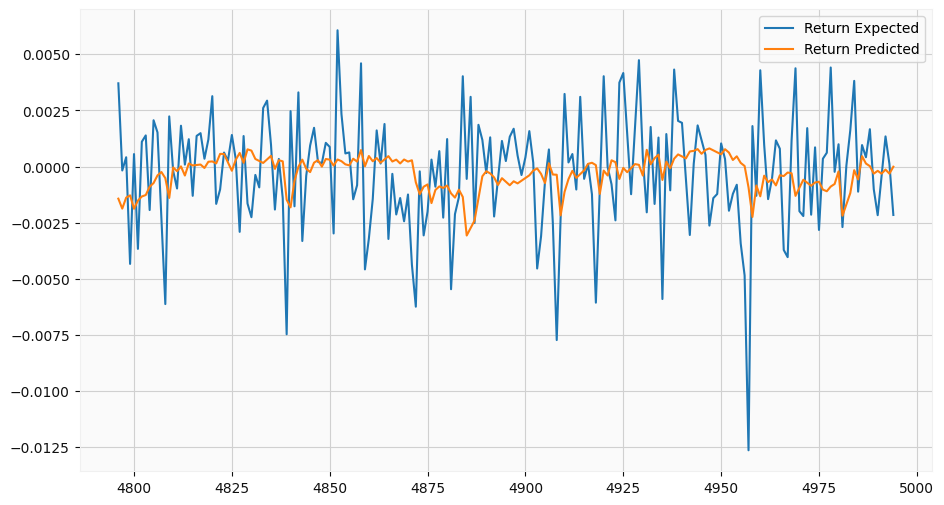

In [33]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-200:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-200:].plot(y="Return Predicted",ax=axs)